# **Machine Learning on Big Data (CN7030) CRWK 24-25 Term B [60% weighting]**
# **Group ID: [Your Group ID]**
1.   Student 1: Muhammad Jahanzaib Ali Khan - 2959951
2.   Student 2: Ammad Ali - 2850666
3.   Student 3: Hannan - 2934637

---

If you want to add comments on your group work, please write it here for us:

[link text](https://)
# **Initiate and Configure Spark**

In [ ]:
pip install pyspark matplotlib seaborn pandas pyarrow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import col
import pyspark.sql.functions as F
from pyspark.sql.functions import col, explode, array, lit
from pyspark.ml.feature import StringIndexer, Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ✅ Initialize Spark session with optimized configuration for speed
spark = SparkSession.builder \
    .appName("CN7030 Text Classification with Optimized Performance") \
    .master("local[*]") \
    .config("spark.executor.memory", "6g") \
    .config("spark.driver.memory", "6g") \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size", "4g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.default.parallelism", "8") \
    .getOrCreate()

print("✅ Optimized Spark session initialized successfully")

✅ Optimized Spark session initialized successfully


---
# **Task 1 - Data Loading and Preprocessing (15 marks)**
---

In [42]:
# Make sure to update the path to your file
df = spark.read.format("csv") \
    .option("header", True) \
    .option("multiLine", True) \
    .option("quote", '"') \
    .option("escape", '"') \
    .option("inferSchema", True) \
    .option("mode", "PERMISSIVE") \
    .load("complaints-2025-08-06_16_14(1).csv")

In [43]:
print(f"Total rows: {df.count()}, Total columns: {len(df.columns)}")
df.printSchema()
df.show(5)

Total rows: 278884, Total columns: 18
root
 |-- Date received: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Sub-product: string (nullable = true)
 |-- Issue: string (nullable = true)
 |-- Sub-issue: string (nullable = true)
 |-- Consumer complaint narrative: string (nullable = true)
 |-- Company public response: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ZIP code: string (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Consumer consent provided?: string (nullable = true)
 |-- Submitted via: string (nullable = true)
 |-- Date sent to company: string (nullable = true)
 |-- Company response to consumer: string (nullable = true)
 |-- Timely response?: string (nullable = true)
 |-- Consumer disputed?: string (nullable = true)
 |-- Complaint ID: integer (nullable = true)

+-------------+--------------------+----------------+--------------------+--------------------+----------------------------+--

Rows before dropping nulls: 267991
Rows after dropping nulls: 267991 (0.00% removed)

Data split. Train rows: 187440, Test rows: 80551

Labels encoded based on training data vocabulary.
+---------------------------+-----+
|Product                    |label|
+---------------------------+-----+
|Checking or savings account|2.0  |
|Checking or savings account|2.0  |
|Checking or savings account|2.0  |
|Checking or savings account|2.0  |
|Checking or savings account|2.0  |
+---------------------------+-----+
only showing top 5 rows

Addressing class imbalance with oversampling on the training set...
Oversampling complete. Training rows before: 187440, Training rows after: 909310


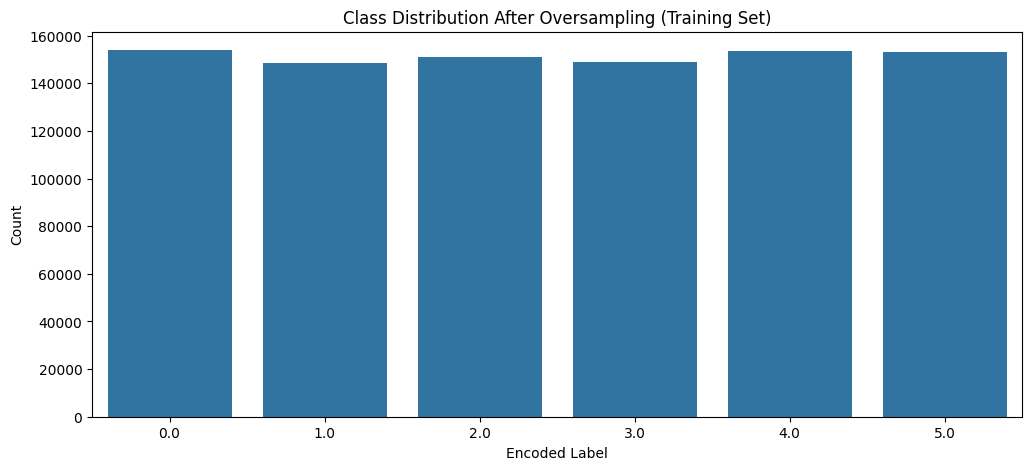

Optimizing dataframe with 8 partitions...
Dataframe optimized and cached with 909310 rows.
Optimizing dataframe with 4 partitions...
Dataframe optimized and cached with 80551 rows.

Final Train rows: 909310, Final Test rows: 80551


In [40]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, array, lit
from pyspark.ml.feature import StringIndexer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assume 'spark' session and 'df' dataframe are already initialized and loaded
# The initial dataframe 'df' should be the original, raw data.

# --- 1.1 Data Preparation (Cleaning) ---
# Select relevant columns and drop nulls
df = df.select("Product", "Consumer complaint narrative")
rows_before = df.count()
df = df.dropna(subset=["Product", "Consumer complaint narrative"])
rows_after = df.count()
print(f"Rows before dropping nulls: {rows_before}")
print(f"Rows after dropping nulls: {rows_after} ({(rows_before - rows_after)/rows_before*100:.2f}% removed)")

# --- 1.2 Split Data Before Any Processing to Prevent Leakage ---
# Split the dataframe into train and test sets.
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)
print(f"\nData split. Train rows: {train_df.count()}, Test rows: {test_df.count()}")

# --- 1.3 Encode String Labels to Numerical Labels ---
# Fit the indexer ONLY on the training data to prevent data leakage from the test set.
indexer = StringIndexer(inputCol="Product", outputCol="label")
indexer_model = indexer.fit(train_df)

# Transform both the training and test sets using the fitted indexer model.
train_df = indexer_model.transform(train_df)
test_df = indexer_model.transform(test_df)
print("\nLabels encoded based on training data vocabulary.")
train_df.select("Product", "label").show(5, truncate=False)

# --- 1.4 Address Class Imbalance with Oversampling (on TRAINING data only) ---
print("\nAddressing class imbalance with oversampling on the training set...")
train_class_counts = train_df.groupBy("label").count().orderBy("count", ascending=False).toPandas()
major_class_count = train_class_counts.iloc[0]['count']
ratios = train_df.groupBy("label").count().withColumn("ratio", major_class_count / col("count")).select("label", "ratio").collect()

oversampled_train_df = train_df
for row in ratios:
    label = row["label"]
    ratio = int(row["ratio"])
    if ratio > 1:
        minority_df = train_df.filter(col("label") == label)
        # Duplicate the minority class rows to balance the dataset
        oversampled_train_df = oversampled_train_df.unionAll(minority_df.withColumn("dummy", explode(array([lit(i) for i in range(ratio - 1)]))).drop("dummy"))

print(f"Oversampling complete. Training rows before: {train_df.count()}, Training rows after: {oversampled_train_df.count()}")

# --- 1.5 Visualize Class Distribution (on the oversampled training data) ---
oversampled_counts = oversampled_train_df.groupBy("label").count().orderBy("count", ascending=False).toPandas()
plt.figure(figsize=(12, 5))
sns.barplot(x="label", y="count", data=oversampled_counts)
plt.title("Class Distribution After Oversampling (Training Set)")
plt.xlabel("Encoded Label")
plt.ylabel("Count")
plt.show()

# --- 1.6 Optimize Partitions ---
def optimize_dataframe(df, target_partitions=8, cache=True):
    """Function to repartition and cache a DataFrame."""
    print(f"Optimizing dataframe with {target_partitions} partitions...")
    df_optimized = df.repartition(target_partitions)
    if cache:
        df_optimized.cache()
        count = df_optimized.count() # Trigger caching
        print(f"Dataframe optimized and cached with {count} rows.")
    return df_optimized

# Optimize the oversampled training set and the untouched test set
train_df_opt = optimize_dataframe(oversampled_train_df, target_partitions=8)
test_df_opt = optimize_dataframe(test_df, target_partitions=4)

print(f"\nFinal Train rows: {train_df_opt.count()}, Final Test rows: {test_df_opt.count()}")

# **Undersampling**


Addressing class imbalance with undersampling on the training set...
Undersampling complete. Training rows before: 187440, Training rows after: 11415


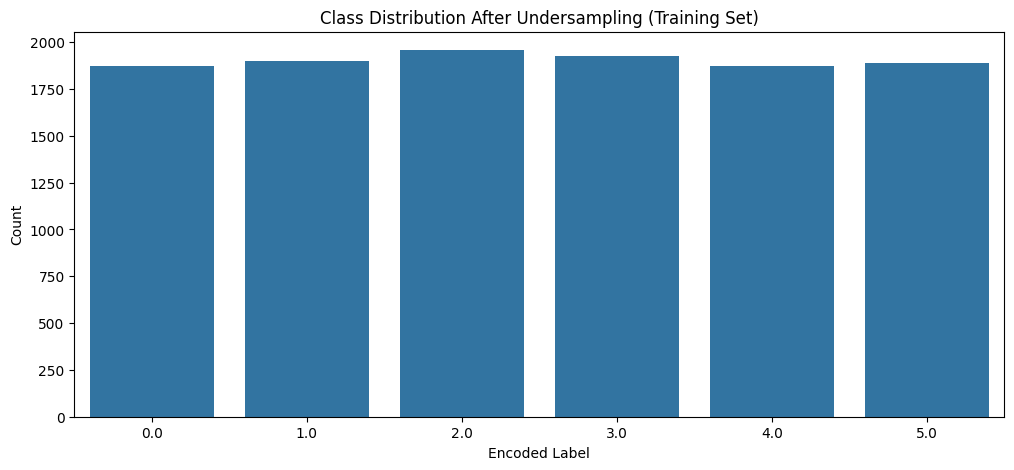

Optimizing dataframe with 8 partitions...
Dataframe optimized and cached with 11415 rows.
Optimizing dataframe with 4 partitions...
Dataframe optimized and cached with 80551 rows.

Final Undersampled Train rows: 11415, Final Undersampled Test rows: 80551


In [28]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assume 'spark' session, 'train_df', and 'test_df' are already initialized.
# 'train_df' and 'test_df' are the dataframes after the initial 70/30 split and label encoding.

# This function definition is included for completeness as it's used below.
def optimize_dataframe(df, target_partitions=8, cache=True):
    """Function to repartition and cache a DataFrame."""
    print(f"Optimizing dataframe with {target_partitions} partitions...")
    df_optimized = df.repartition(target_partitions)
    if cache:
        df_optimized.cache()
        count = df_optimized.count() # Trigger caching
        print(f"Dataframe optimized and cached with {count} rows.")
    return df_optimized

# --- 2.1 Undersampling on TRAINING data only ---
print("\nAddressing class imbalance with undersampling on the training set...")

# Get the count of each class in training set
train_class_counts_pd = train_df.groupBy("label").count().orderBy("count").toPandas()
minor_class_count = train_class_counts_pd.iloc[0]['count']

# Create sampling fractions for each class
fractions = {
    row['label']: float(minor_class_count) / row['count']
    if row['count'] > minor_class_count else 1.0
    for _, row in train_class_counts_pd.iterrows()
}

# Apply stratified sampling in one shot
undersampled_train_df = train_df.sampleBy("label", fractions, seed=42)

print(f"Undersampling complete. Training rows before: {train_df.count()}, Training rows after: {undersampled_train_df.count()}")

# --- 2.2 Visualize Class Distribution (on the undersampled training data) ---
undersampled_counts = undersampled_train_df.groupBy("label").count().orderBy("count", ascending=False).toPandas()

plt.figure(figsize=(12, 5))
sns.barplot(x="label", y="count", data=undersampled_counts)
plt.title("Class Distribution After Undersampling (Training Set)")
plt.xlabel("Encoded Label")
plt.ylabel("Count")
plt.show()

# --- 2.3 Optimize Partitions for Undersampled Data ---
train_df_undersampled_opt = optimize_dataframe(undersampled_train_df, target_partitions=8)
test_df_undersampled_opt = optimize_dataframe(test_df, target_partitions=4)

print(f"\nFinal Undersampled Train rows: {train_df_undersampled_opt.count()}, Final Undersampled Test rows: {test_df_undersampled_opt.count()}")

# **Class Weighting**


Calculating class weights for the training set...
Class weights calculated and added as a new column.
+---------------------------+-----+-----------------+
|Product                    |label|classWeight      |
+---------------------------+-----+-----------------+
|Checking or savings account|2.0  |4.754946727549467|
|Checking or savings account|2.0  |4.754946727549467|
|Checking or savings account|2.0  |4.754946727549467|
|Checking or savings account|2.0  |4.754946727549467|
|Checking or savings account|2.0  |4.754946727549467|
+---------------------------+-----+-----------------+
only showing top 5 rows


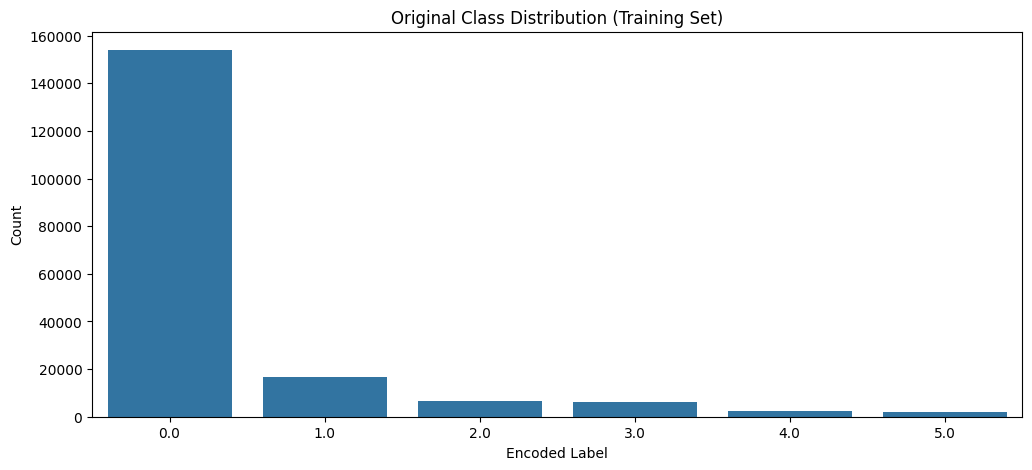

Optimizing dataframe with 8 partitions...
Dataframe optimized and cached with 187440 rows.
Optimizing dataframe with 4 partitions...
Dataframe optimized and cached with 80551 rows.

Final Class Weighted Train rows: 187440, Final Class Weighted Test rows: 80551


In [29]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assume 'spark' session, 'train_df', and 'test_df' are already initialized.
# 'train_df' and 'test_df' are the dataframes after the initial 70/30 split and label encoding.

# This function definition is included for completeness as it's used below.
def optimize_dataframe(df, target_partitions=8, cache=True):
    """Function to repartition and cache a DataFrame."""
    print(f"Optimizing dataframe with {target_partitions} partitions...")
    df_optimized = df.repartition(target_partitions)
    if cache:
        df_optimized.cache()
        count = df_optimized.count() # Trigger caching
        print(f"Dataframe optimized and cached with {count} rows.")
    return df_optimized

# --- 3.1 Class Weighting (no modification to the dataset size) ---
print("\nCalculating class weights for the training set...")

# Calculate class counts
class_counts_df = train_df.groupBy("label").count()
class_counts_pd = class_counts_df.toPandas()

total_samples = class_counts_pd['count'].sum()
num_classes = len(class_counts_pd)

# Calculate weights: total_samples / (num_classes * count)
class_counts_pd['weight'] = total_samples / (num_classes * class_counts_pd['count'])

# Convert to dict {label: weight}
weights_dict = class_counts_pd.set_index('label')['weight'].to_dict()

# Broadcast weights to executors (more efficient than Python UDF)
mapping_expr = F.create_map([F.lit(x) for kv in weights_dict.items() for x in kv])

# Add classWeight column using Spark expression
train_df_weights = train_df.withColumn("classWeight", mapping_expr[F.col("label")])

print("Class weights calculated and added as a new column.")
train_df_weights.select("Product", "label", "classWeight").show(5, truncate=False)

# Visualize the original imbalanced class distribution
plt.figure(figsize=(12, 5))
sns.barplot(x="label", y="count", data=class_counts_pd)
plt.title("Original Class Distribution (Training Set)")
plt.xlabel("Encoded Label")
plt.ylabel("Count")
plt.show()

# --- 3.2 Optimize Partitions for Class Weighted Data ---
train_df_weights_opt = optimize_dataframe(train_df_weights, target_partitions=8)
test_df_weights_opt = optimize_dataframe(test_df, target_partitions=4)

print(f"\nFinal Class Weighted Train rows: {train_df_weights_opt.count()}, Final Class Weighted Test rows: {test_df_weights_opt.count()}")

---
# **Task 2 - Model Selection and Implementation (25 marks)**
---


In [30]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

# =================================================================
# ## Task 2: Model Implementation (Oversampling)
# =================================================================
# ## 2nd student name: Ammad Ali

# --- 2.0 Data Splitting for Validation ---
# Split the oversampled training data into training (80%) and validation (20%) sets
(train_oversampled, validation_oversampled) = train_df_opt.randomSplit([0.8, 0.2], seed=42)

print("Oversampled data split complete.")
print(f"Training set size: {train_oversampled.count()}")
print(f"Validation set size: {validation_oversampled.count()}")


# --- 2.1 Feature Engineering Pipeline for Text ---
# Stage 1: Tokenize the complaint text
tokenizer = Tokenizer(inputCol="Consumer complaint narrative", outputCol="words")
# Stage 2: Remove common stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
# Stage 3: Convert words to feature vectors using HashingTF
hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=5000)
# Stage 4: Apply Inverse Document Frequency (IDF) to scale the features
idf = IDF(inputCol="raw_features", outputCol="features")

# --- 2.2 Model Selection: Random Forest ---
# Stage 5: Define the Random Forest classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=42)

# --- 2.3 Create and Run the Full ML Pipeline ---
# Combine all stages into a single pipeline
pipeline_oversampled = Pipeline(stages=[tokenizer, remover, hashingTF, idf, rf])

# Train the model
model_oversampled = pipeline_oversampled.fit(train_oversampled)

# Make predictions on the validation data
predictions_oversampled = model_oversampled.transform(validation_oversampled)

print("\nML Pipeline for Oversampling created and trained successfully.")
print("Pipeline Stages:", [stage.__class__.__name__ for stage in pipeline_oversampled.getStages()])

Oversampled data split complete.
Training set size: 727768
Validation set size: 181542

ML Pipeline for Oversampling created and trained successfully.
Pipeline Stages: ['Tokenizer', 'StopWordsRemover', 'HashingTF', 'IDF', 'RandomForestClassifier']


In [31]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

# =================================================================
# ## Task 2: Model Implementation (Undersampling)
# =================================================================
# ## 2nd student name: Ammad Ali

# Assume 'train_df_undersampled_opt' is available from the previous script.

# --- 2.0 Data Splitting ---
# Split the undersampled training data into training (80%) and validation (20%) sets
(train_undersampled, validation_undersampled) = train_df_undersampled_opt.randomSplit([0.8, 0.2], seed=42)

print("Undersampled data split complete.")
print(f"Training set size: {train_undersampled.count()}")
print(f"Validation set size: {validation_undersampled.count()}")

# --- 2.1 Feature Engineering Pipeline for Text ---
# Stage 1: Tokenize the complaint text
tokenizer = Tokenizer(inputCol="Consumer complaint narrative", outputCol="words")
# Stage 2: Remove common stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
# Stage 3: Convert words to feature vectors using HashingTF
hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=5000)
# Stage 4: Apply Inverse Document Frequency (IDF) to scale the features
idf = IDF(inputCol="raw_features", outputCol="features")

# --- 2.2 Model Selection: Random Forest ---
# Stage 5: Define the Random Forest classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=42)

# --- 2.3 Create and Run the Full ML Pipeline ---
# Combine all stages into a single pipeline
pipeline_undersampled = Pipeline(stages=[tokenizer, remover, hashingTF, idf, rf])

# Train the model
model_undersampled = pipeline_undersampled.fit(train_undersampled)

# Make predictions on the validation data
predictions_undersampled = model_undersampled.transform(validation_undersampled)

print("\nML Pipeline for Undersampling created and trained successfully.")
print("Pipeline Stages:", [stage.__class__.__name__ for stage in pipeline_undersampled.getStages()])

Undersampled data split complete.
Training set size: 9186
Validation set size: 2229

ML Pipeline for Undersampling created and trained successfully.
Pipeline Stages: ['Tokenizer', 'StopWordsRemover', 'HashingTF', 'IDF', 'RandomForestClassifier']


In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

# =================================================================
# ## Task 2: Model Implementation (Class Weighting)
# =================================================================
# ## 2nd student name: Ammad Ali

# Assume 'train_df_weights_opt' is available from the previous script.

# --- 2.0 Data Splitting ---
(train_weighted, validation_weighted) = train_df_weights_opt.randomSplit([0.8, 0.2], seed=42)

print("Weighted data split complete.")
print(f"Training set size: {train_weighted.count()}")
print(f"Validation set size: {validation_weighted.count()}")

# --- 2.1 Feature Engineering Pipeline for Text ---
tokenizer = Tokenizer(inputCol="Consumer complaint narrative", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=5000)
idf = IDF(inputCol="raw_features", outputCol="features")

# --- 2.2 Model Selection: Random Forest with Class Weights ---
rf_weighted = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    weightCol="classWeight",   # ✅ Telling the model to use the weight column
    seed=42
)

# --- 2.3 Create and Run the Full ML Pipeline ---
pipeline_weighted = Pipeline(stages=[tokenizer, remover, hashingTF, idf, rf_weighted])

# Train the model
model_weighted = pipeline_weighted.fit(train_weighted)

# Make predictions on the validation data
predictions_weighted = model_weighted.transform(validation_weighted)

print("\nML Pipeline for Class Weighting created and trained successfully.")
print("Pipeline Stages:", [stage.__class__.__name__ for stage in pipeline_weighted.getStages()])

Weighted data split complete.
Training set size: 150196
Validation set size: 37244

ML Pipeline for Class Weighting created and trained successfully.
Pipeline Stages: ['Tokenizer', 'StopWordsRemover', 'HashingTF', 'IDF', 'RandomForestClassifier']


---
# **Task 3 - Model Parameter Tuning (20 marks)**
---


In [33]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# =================================================================
# ## Task 3: Model Tuning with TrainValidationSplit (Oversampling)
# =================================================================
# ## 3rd student name: Ammad Ali

# --- 3.1 Define Parameter Grid & Evaluator ---
paramGrid_oversampled = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# --- 3.2 Set up and Run TrainValidationSplit ---
# This will split the data one time to tune parameters.
# trainRatio=0.8 means 80% of the input data is used for training, 20% for validation.
tvs_oversampled = TrainValidationSplit(estimator=pipeline_oversampled,
                                       estimatorParamMaps=paramGrid_oversampled,
                                       evaluator=evaluator,
                                       trainRatio=0.8) # 80% for training, 20% for validation

print("\nStarting model tuning for OVERSAMPLED data with TrainValidationSplit... ⏳")
# Fit the validator to the training data.
tvsModel_oversampled = tvs_oversampled.fit(train_oversampled)
print("Oversampling model tuning completed. ✅")

# --- 3.3 Get the Best Model ---
bestModel_oversampled = tvsModel_oversampled.bestModel
print("\nBest model for oversampled data extracted from TrainValidationSplit.")


Starting model tuning for OVERSAMPLED data with TrainValidationSplit... ⏳
Oversampling model tuning completed. ✅

Best model for oversampled data extracted from TrainValidationSplit.


In [34]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# =================================================================
# ## Task 3: Model Tuning with TrainValidationSplit (Undersampling)
# =================================================================
# ## 3rd student name: Ammad Ali

# --- 3.1 Define Parameter Grid & Evaluator ---
paramGrid_undersampled = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# --- 3.2 Set up and Run TrainValidationSplit ---
tvs_undersampled = TrainValidationSplit(estimator=pipeline_undersampled,
                                        estimatorParamMaps=paramGrid_undersampled,
                                        evaluator=evaluator,
                                        trainRatio=0.8)

print("\nStarting model tuning for UNDERSAMPLED data with TrainValidationSplit... ⏳")
# Fit the validator to the undersampled training data.
tvsModel_undersampled = tvs_undersampled.fit(train_undersampled)
print("Undersampling model tuning completed. ✅")

# --- 3.3 Get the Best Model ---
bestModel_undersampled = tvsModel_undersampled.bestModel
print("\nBest model for undersampled data extracted from TrainValidationSplit.")


Starting model tuning for UNDERSAMPLED data with TrainValidationSplit... ⏳
Undersampling model tuning completed. ✅

Best model for undersampled data extracted from TrainValidationSplit.


In [35]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# =================================================================
# ## Task 3: Model Tuning with TrainValidationSplit (Class Weighting)
# =================================================================
# ## 3rd student name: Ammad Ali

# --- 3.1 Define Parameter Grid & Evaluator ---
# Use the rf_weighted object from the class weighting pipeline.
paramGrid_weighted = ParamGridBuilder() \
    .addGrid(rf_weighted.numTrees, [50, 100]) \
    .addGrid(rf_weighted.maxDepth, [5, 10]) \
    .build()

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# --- 3.2 Set up and Run TrainValidationSplit ---
# The estimator (pipeline_weighted) already has the weighted classifier configured.
tvs_weighted = TrainValidationSplit(estimator=pipeline_weighted,
                                    estimatorParamMaps=paramGrid_weighted,
                                    evaluator=evaluator,
                                    trainRatio=0.8)

print("\nStarting model tuning for CLASS WEIGHTING data with TrainValidationSplit... ⏳")
# Fit the validator to the weighted training data.
tvsModel_weighted = tvs_weighted.fit(train_weighted)
print("Class weighting model tuning completed. ✅")

# --- 3.3 Get the Best Model ---
bestModel_weighted = tvsModel_weighted.bestModel
print("\nBest model for class weighting data extracted from TrainValidationSplit.")


Starting model tuning for CLASS WEIGHTING data with TrainValidationSplit... ⏳
Class weighting model tuning completed. ✅

Best model for class weighting data extracted from TrainValidationSplit.


---
# **Task 4 - Model Evaluation and Accuracy Calculation (20 marks)**
---

In [36]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# =================================================================
# ## Task 4: Evaluation of the Best Oversampling Model
# =================================================================
# ## 1st student name: Ammad Ali

# Assume 'bestModel_oversampled' and 'test_df_opt' are available.

# --- 4.1 Make Predictions on Test Data ---
print("\nMaking predictions with the best OVERSAMPLED model on the test set...")
# Use the untouched, optimized test data for final evaluation.
predictions_oversampled = bestModel_oversampled.transform(test_df_opt)
print("Predictions generated.")

# --- 4.2 Calculate Performance Metrics ---
print("\n--- Oversampled Model Performance Metrics ---")

# Define evaluators for different metrics
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

# Calculate and print each metric
accuracy = evaluator_accuracy.evaluate(predictions_oversampled)
print(f"Accuracy: {accuracy * 100:.2f}%")

f1_score = evaluator_f1.evaluate(predictions_oversampled)
print(f"F1-Score (Weighted): {f1_score:.2f}")

precision = evaluator_precision.evaluate(predictions_oversampled)
print(f"Weighted Precision: {precision:.2f}")

recall = evaluator_recall.evaluate(predictions_oversampled)
print(f"Weighted Recall: {recall:.2f}")


Making predictions with the best OVERSAMPLED model on the test set...
Predictions generated.

--- Oversampled Model Performance Metrics ---
Accuracy: 80.30%
F1-Score (Weighted): 0.83
Weighted Precision: 0.87
Weighted Recall: 0.80


In [37]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# =================================================================
# ## Task 4: Evaluation of the Best Undersampling Model
# =================================================================
# ## 1st student name: Ammad Ali

# Assume 'bestModel_undersampled' and 'test_df_undersampled_opt' are available.

# --- 4.1 Make Predictions on Test Data ---
print("\nMaking predictions with the best UNDERSAMPLED model on the test set...")
# Use the untouched, optimized test data for final evaluation.
predictions_undersampled = bestModel_undersampled.transform(test_df_undersampled_opt)
print("Predictions generated.")

# --- 4.2 Calculate Performance Metrics ---
print("\n--- Undersampled Model Performance Metrics ---")

# Define evaluators for different metrics
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

# Calculate and print each metric
accuracy = evaluator_accuracy.evaluate(predictions_undersampled)
print(f"Accuracy: {accuracy * 100:.2f}%")

f1_score = evaluator_f1.evaluate(predictions_undersampled)
print(f"F1-Score (Weighted): {f1_score:.2f}")

precision = evaluator_precision.evaluate(predictions_undersampled)
print(f"Weighted Precision: {precision:.2f}")

recall = evaluator_recall.evaluate(predictions_undersampled)
print(f"Weighted Recall: {recall:.2f}")


Making predictions with the best UNDERSAMPLED model on the test set...
Predictions generated.

--- Undersampled Model Performance Metrics ---
Accuracy: 82.92%
F1-Score (Weighted): 0.85
Weighted Precision: 0.89
Weighted Recall: 0.83


In [38]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# =================================================================
# ## Task 4: Evaluation of the Best Class Weighting Model
# =================================================================
# ## 1st student name: Ammad Ali

# Assume 'bestModel_weighted' and 'test_df_weights_opt' are available.

# --- 4.1 Make Predictions on Test Data ---
print("\nMaking predictions with the best CLASS WEIGHTING model on the test set...")
# Use the untouched, optimized test data for final evaluation.
predictions_weighted = bestModel_weighted.transform(test_df_weights_opt)
print("Predictions generated.")

# --- 4.2 Calculate Performance Metrics ---
print("\n--- Class Weighting Model Performance Metrics ---")

# Define evaluators for different metrics
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

# Calculate and print each metric
accuracy = evaluator_accuracy.evaluate(predictions_weighted)
print(f"Accuracy: {accuracy * 100:.2f}%")

f1_score = evaluator_f1.evaluate(predictions_weighted)
print(f"F1-Score (Weighted): {f1_score:.2f}")

precision = evaluator_precision.evaluate(predictions_weighted)
print(f"Weighted Precision: {precision:.2f}")

recall = evaluator_recall.evaluate(predictions_weighted)
print(f"Weighted Recall: {recall:.2f}")


Making predictions with the best CLASS WEIGHTING model on the test set...
Predictions generated.

--- Class Weighting Model Performance Metrics ---
Accuracy: 84.86%
F1-Score (Weighted): 0.87
Weighted Precision: 0.90
Weighted Recall: 0.85


---
# **Task 5 - Results Visualization or Printing (5 marks)**
---


Sample Predictions from Oversampled Model (Actual vs. Predicted):
+---------------------------------------------------+-----+----------+
|Product                                            |label|prediction|
+---------------------------------------------------+-----+----------+
|Credit reporting or other personal consumer reports|0.0  |0.0       |
|Credit reporting or other personal consumer reports|0.0  |0.0       |
|Credit reporting or other personal consumer reports|0.0  |1.0       |
|Credit reporting or other personal consumer reports|0.0  |0.0       |
|Credit reporting or other personal consumer reports|0.0  |0.0       |
|Credit reporting or other personal consumer reports|0.0  |0.0       |
|Credit reporting or other personal consumer reports|0.0  |1.0       |
|Credit reporting or other personal consumer reports|0.0  |0.0       |
|Credit reporting or other personal consumer reports|0.0  |0.0       |
|Credit reporting or other personal consumer reports|0.0  |0.0       |
|Mortgage 

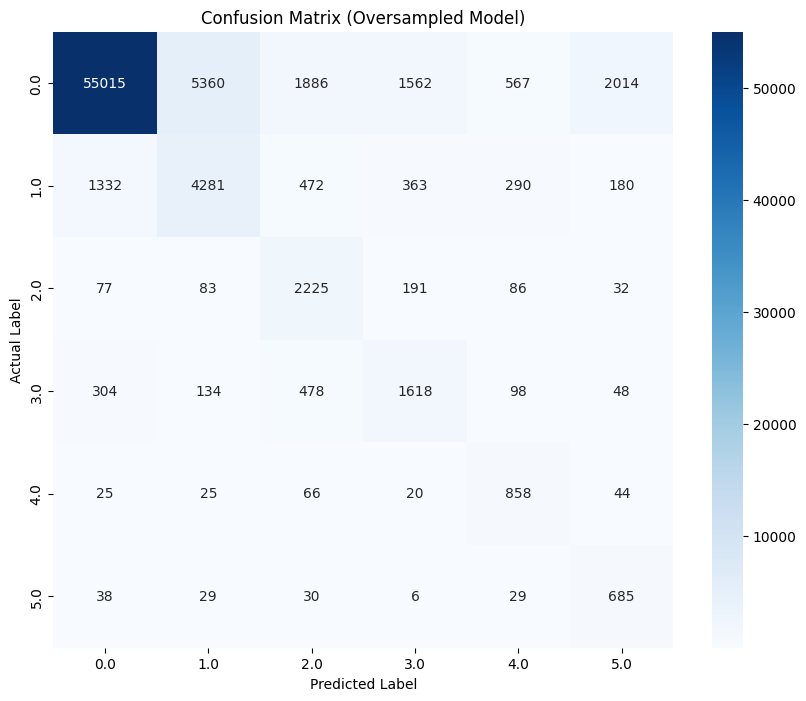


Oversampling visualization finished successfully!


In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# =================================================================
# ## Task 5: Results Visualization (Oversampling Model)
# =================================================================
# ## 2nd student name: Ammad Ali

# --- 5.1 Show Sample Predictions ---
print("\nSample Predictions from Oversampled Model (Actual vs. Predicted):")
predictions_oversampled.select("Product", "label", "prediction").show(20, truncate=False)

# --- 5.2 Generate and Display Confusion Matrix ---
print("\nGenerating Confusion Matrix for Oversampled Model...")
# Convert Spark DataFrame to Pandas for visualization
class_temp_oversampled = predictions_oversampled.select("label", "prediction").toPandas()
confusion_matrix_df = pd.crosstab(class_temp_oversampled['label'], class_temp_oversampled['prediction'],
                                  rownames=['Actual Label'], colnames=['Predicted Label'])

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Oversampled Model)')
plt.show()

print("\nOversampling visualization finished successfully!")


Sample Predictions from Undersampled Model (Actual vs. Predicted):
+---------------------------------------------------+-----+----------+
|Product                                            |label|prediction|
+---------------------------------------------------+-----+----------+
|Credit reporting or other personal consumer reports|0.0  |0.0       |
|Credit reporting or other personal consumer reports|0.0  |0.0       |
|Credit reporting or other personal consumer reports|0.0  |1.0       |
|Credit reporting or other personal consumer reports|0.0  |0.0       |
|Credit reporting or other personal consumer reports|0.0  |0.0       |
|Credit reporting or other personal consumer reports|0.0  |0.0       |
|Credit reporting or other personal consumer reports|0.0  |1.0       |
|Credit reporting or other personal consumer reports|0.0  |0.0       |
|Credit reporting or other personal consumer reports|0.0  |0.0       |
|Credit reporting or other personal consumer reports|0.0  |0.0       |
|Mortgage

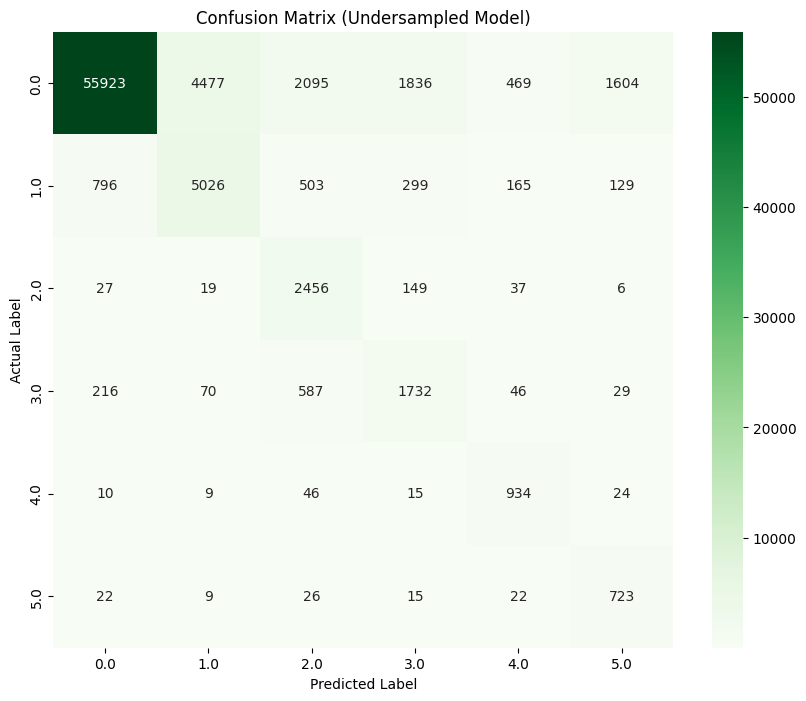


Undersampling visualization finished successfully!


In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# =================================================================
# ## Task 5: Results Visualization (Undersampling Model)
# =================================================================
# ## 2nd student name: Ammad Ali

# --- 5.1 Show Sample Predictions ---
print("\nSample Predictions from Undersampled Model (Actual vs. Predicted):")
predictions_undersampled.select("Product", "label", "prediction").show(20, truncate=False)

# --- 5.2 Generate and Display Confusion Matrix ---
print("\nGenerating Confusion Matrix for Undersampled Model...")
# Convert Spark DataFrame to Pandas for visualization
class_temp_undersampled = predictions_undersampled.select("label", "prediction").toPandas()
confusion_matrix_df = pd.crosstab(class_temp_undersampled['label'], class_temp_undersampled['prediction'],
                                  rownames=['Actual Label'], colnames=['Predicted Label'])

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_df, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (Undersampled Model)')
plt.show()

print("\nUndersampling visualization finished successfully!")


Sample Predictions from Class Weighting Model (Actual vs. Predicted):
+---------------------------------------------------+-----+----------+
|Product                                            |label|prediction|
+---------------------------------------------------+-----+----------+
|Credit reporting or other personal consumer reports|0.0  |0.0       |
|Credit reporting or other personal consumer reports|0.0  |0.0       |
|Credit reporting or other personal consumer reports|0.0  |0.0       |
|Credit reporting or other personal consumer reports|0.0  |0.0       |
|Credit reporting or other personal consumer reports|0.0  |0.0       |
|Credit reporting or other personal consumer reports|0.0  |0.0       |
|Credit reporting or other personal consumer reports|0.0  |0.0       |
|Credit reporting or other personal consumer reports|0.0  |0.0       |
|Credit reporting or other personal consumer reports|0.0  |0.0       |
|Credit reporting or other personal consumer reports|0.0  |0.0       |
|Mortg

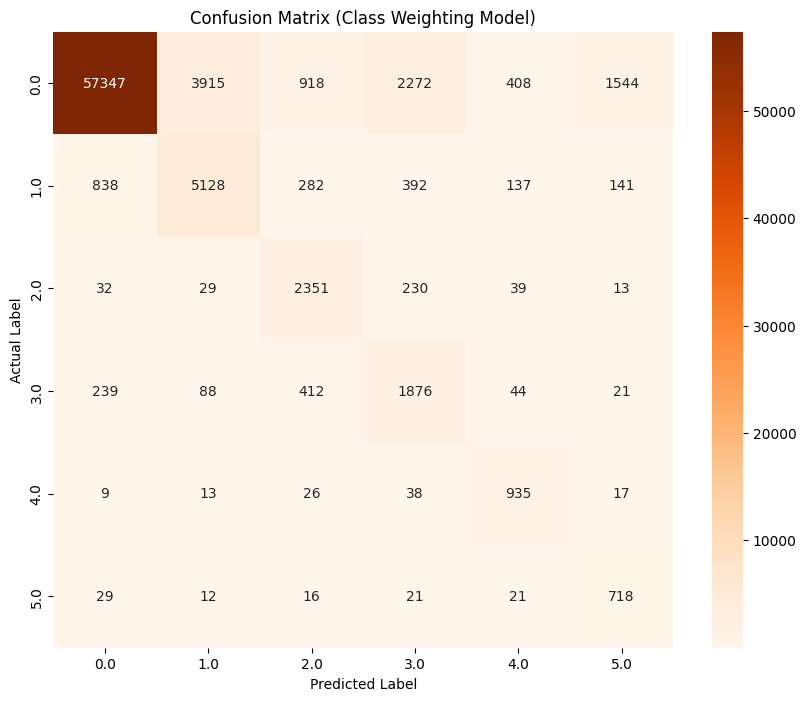


Class weighting visualization finished successfully!


In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# =================================================================
# ## Task 5: Results Visualization (Class Weighting Model)
# =================================================================
# ## 2nd student name: Ammad Ali

# --- 5.1 Show Sample Predictions ---
print("\nSample Predictions from Class Weighting Model (Actual vs. Predicted):")
predictions_weighted.select("Product", "label", "prediction").show(20, truncate=False)

# --- 5.2 Generate and Display Confusion Matrix ---
print("\nGenerating Confusion Matrix for Class Weighting Model...")
# Convert Spark DataFrame to Pandas for visualization
class_temp_weighted = predictions_weighted.select("label", "prediction").toPandas()
confusion_matrix_df = pd.crosstab(class_temp_weighted['label'], class_temp_weighted['prediction'],
                                  rownames=['Actual Label'], colnames=['Predicted Label'])

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_df, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix (Class Weighting Model)')
plt.show()

print("\nClass weighting visualization finished successfully!")

---
# **Task 6 - LSEP Considerations (10 marks)**
---

# Student 1: **Type the chosen issue**

add contribution here ...

# Student 2: **Type the chosen issue**

add contribution here ...

# Student 3: **Type the chosen issue**

add contribution here ...

---

# **Task 7 - Convert ipynb to HTML for Turnitin submission [5 marks]**

---



In [ ]:
# install nbconvert (if facing the conversion error)
# !pip3 install nbconvert


In [ ]:
# convert ipynb to html and submit this HTML file
# !jupyter nbconvert --to html Your_Group_ID_CRWK_CN7030_Template.ipynb